# Ground Truth 



* **Last Modified**: 10-03-2021
* **Authors**: Satyarth Praveen, J. Emmanuel Johnson, Nadia Ahmed, Nicholas Roth
---
#### Brief Description

In this notebook, we will explore some ways that we can do *tiling* that are necessary for machine learning purposes as well as visualization.  Often times we have images which are absolutely massive and we need to take bits and pieces to be ingested to other models. Obviously visualization is a different. So it does the following:

1. We retrieve all of the information necessary
2. We fuse them to create the ground truth ready to go!

To create the ground truth necessary in the worldfloods data, we need access to water, land and clouds. So let's show how we do this?

---
#### TLDR

> Tiling is a critical component of grabbing images. 

> It uses the WorldFloodsDatasetTiled class that internally tiles the input image and masks. Objects of this class can also be initialized with the transformations to apply transformation to the tiled samples.

> This is useful because it complies with the pytorch datasets that can directly be used for training models.
---

---
#### More Information

* [Tiling](https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html)

In [1]:
# Path based modules to allow us to save files to our local machine
from pyprojroot import here
import sys
import os
root = here(project_files=[".here"])
sys.path.append(str(here()))

import numpy as np
import geopandas as gpd
import pandas as pd
from pathlib import Path
import rasterio
from rasterio import plot as rasterioplt
import numpy as np
import matplotlib.pyplot as plt

from src.data import create_gt
from src.data.utils import GCPPath, read_pickle_from_gcp, get_files_in_directory_gcp

# PLOT Utilities
from src.visualization.plot_utils import plot_s2_rbg_image

%load_ext autoreload
%autoreload 2

## Original Image

Let's load a demo Sentinel-2 (S2) image which will be the basis for all of our demonstrations.

In [2]:
S2_IMG_PATH = "gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/S2/EMSR501/AOI01/EMSR501_AOI01_DEL_MONIT01_r1_v1.tif"


## Demo Plot

We have an easy plot function to visualize the S2 image. 

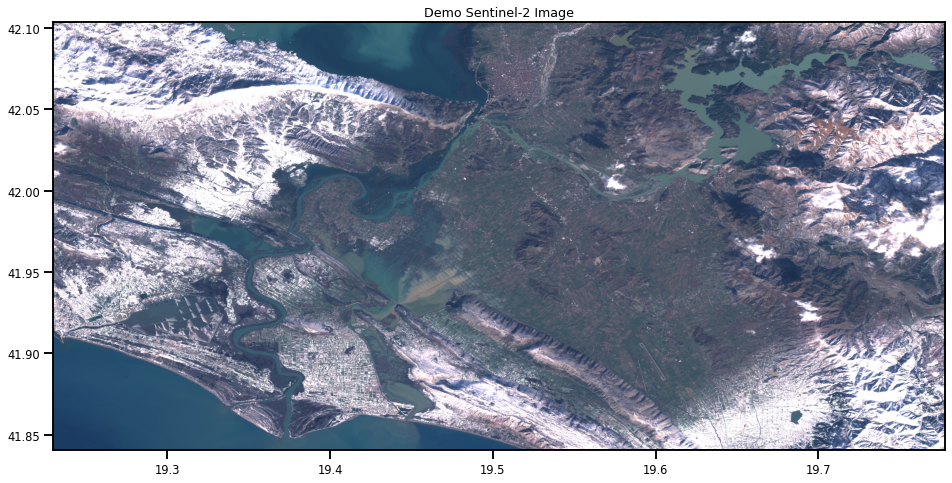

In [3]:
from src.visualization.plot_utils import plot_s2_rbg_image

# initialize figure
fig, ax = plt.subplots(figsize=(16,16))

# prettyu
plot_s2_rbg_image(S2_IMG_PATH, ax=ax)

ax.set(
    title="Demo Sentinel-2 Image",
)
plt.show()

This is mainly for demonstration purposes. For more advanced plotting utilities, please consult a specialized library. 

So now we have our image, let's see what tools we have available to do masks. 

## Cloud Masks

### Last Channel Cloud Probabilities

Fortunately for some of the newer S2 images obtained from GEE, we can simply use the final channel.

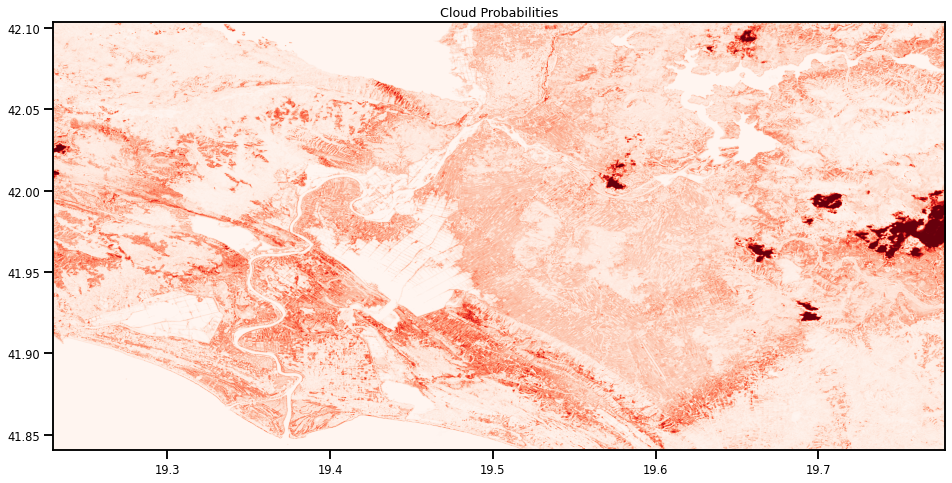

In [4]:
from src.visualization.plot_utils import plot_s2_cloud_prob_image


# initialize figure
fig, ax = plt.subplots(figsize=(16,16))

# plot image
plot_s2_cloud_prob_image(S2_IMG_PATH, ax=ax, cmap="Reds")

ax.set(
    title="Cloud Probabilities",
)
plt.show()

### Model-Based

In other cases where this is not available, we can also use models on the original image. One method that we use within this library is called `s2cloudless`, found [here](https://github.com/sentinel-hub/sentinel2-cloud-detector). This is a model from the sentinel-hub which has a very convenient API for our uses. See [this blog](https://medium.com/sentinel-hub/improving-cloud-detection-with-machine-learning-c09dc5d7cf13) for more details.

Below, we showcase how we can return cloudmasks in a single function within this library. 

**Warnings**: This will take a while to run. Please skip over the section to resume the tutorial.

In [5]:
# %%time
# from src.data.cloud_masks import compute_s2cloudless_probs

# # calculate cloud probabilities using cloudless
# s2_cloud_probs = compute_s2cloudless_probs(S2_IMG_PATH)

#### Figure

In [6]:
# fig, ax = plt.subplots(figsize=(16,16))

# with rasterio.open(S2_IMG_PATH, "r") as s2_rst:
#     transform = s2_rst.transform

# rasterioplt.show(s2_cloud_probs, ax=ax, transform=transform, cmap="Reds")

# ax.set(
#     title="S2CloudLess Cloud Probabilities",
# )
# plt.show()

**Note**: This is actually the same library that is used within the GEE platform! See [this tutorial](https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless) for more information.

## Water Masks

### Permanent Water

So firstly, we have the permanent water. These are streams, rivers and lakes that already exist. This serves as a basis for where the flood events *could* occur.

In [7]:
# permanent water
JRC_IMG_PATH = "gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/JRC/EMSR501/AOI01/EMSR501_AOI01_DEL_MONIT01_r1_v1.tif"

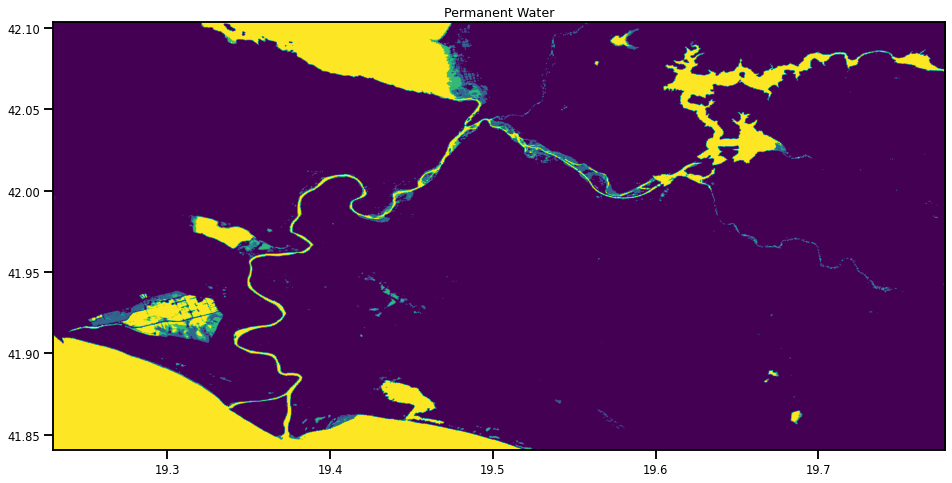

In [8]:
from src.visualization.plot_utils import plot_tiff_image


# initialize figure
fig, ax = plt.subplots(figsize=(16,16))


plot_tiff_image(JRC_IMG_PATH, ax=ax)

ax.set(
    title="Permanent Water",
)
plt.show()

### Flood Events

We need the flood events. These come from the Copernicus EMS data source where we have already preprocessed them to extract the necessary information for floods. These come in the form of `geojson` files which keep all of the polygons indicating the specific coordinates where there was a drought. We can easily read it with the `geopandas` package.

In [9]:
FLOODMAP_PATH = "gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/floodmap/EMSR501/AOI01/EMSR501_AOI01_DEL_MONIT01_r1_v1_floodmap.geojson"

In [10]:
import geopandas as gpd


floodmap_df = gpd.read_file(FLOODMAP_PATH)

In [11]:
floodmap_df[floodmap_df["w_class"] == "Flooded area"]

w_class source                                           geometry
0    Flooded area  flood  POLYGON ((19.48136 42.09515, 19.48136 42.09513...
1    Flooded area  flood  POLYGON ((19.48847 42.09425, 19.48848 42.09408...
2    Flooded area  flood  POLYGON ((19.48667 42.09529, 19.48668 42.09520...
3    Flooded area  flood  POLYGON ((19.47947 42.09510, 19.47947 42.09493...
4    Flooded area  flood  POLYGON ((19.48150 42.09416, 19.48151 42.09372...
..            ...    ...                                                ...
746  Flooded area  flood  POLYGON ((19.40004 41.95977, 19.40107 41.95935...
747  Flooded area  flood  POLYGON ((19.44093 41.99522, 19.44084 41.99522...
748  Flooded area  flood  POLYGON ((19.44152 41.99568, 19.44141 41.99567...
749  Flooded area  flood  POLYGON ((19.44164 41.99577, 19.44152 41.99577...
750  Flooded area  flood  POLYGON ((19.44141 41.99531, 19.44095 41.99531...

[751 rows x 3 columns]

That's it! We can also plot this just to get an overview of the polygons available. Remember the last polygon is the area of interest, so plot all except that one.

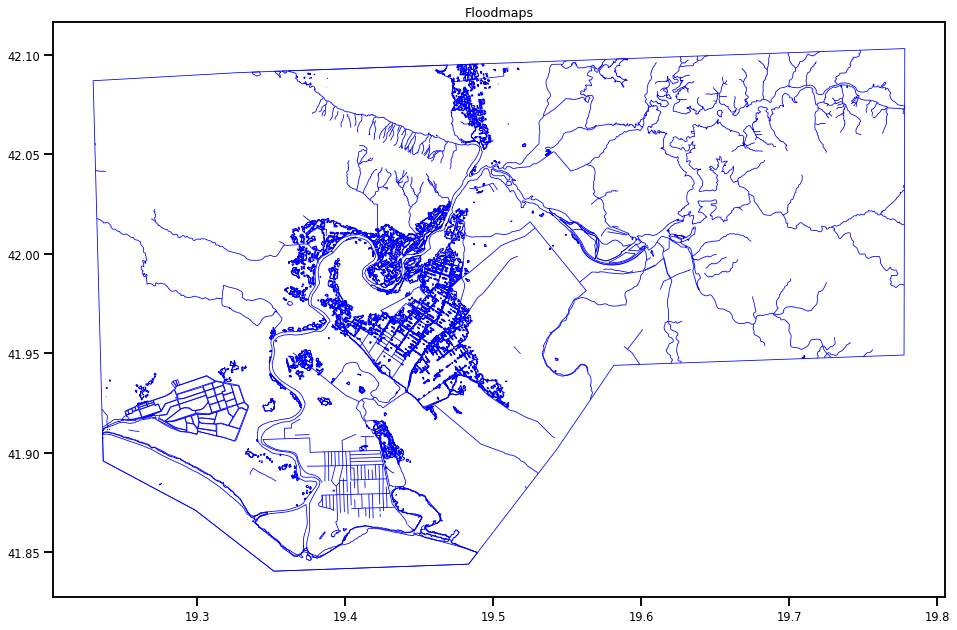

In [12]:

# initialize figure
fig, ax = plt.subplots(figsize=(16,16))

floodmap_df.plot(ax=ax, facecolor="None", edgecolor="blue", label="Flood Maps", linewidth=0.8)

ax.set(
    title="Floodmaps"
)
plt.show()

#### Plot - FloodMaps On Permanent Water

We can also plot the floodmaps on the permanent water to get an overview of how much these flood maps overlap with the already placed permanent water areas.

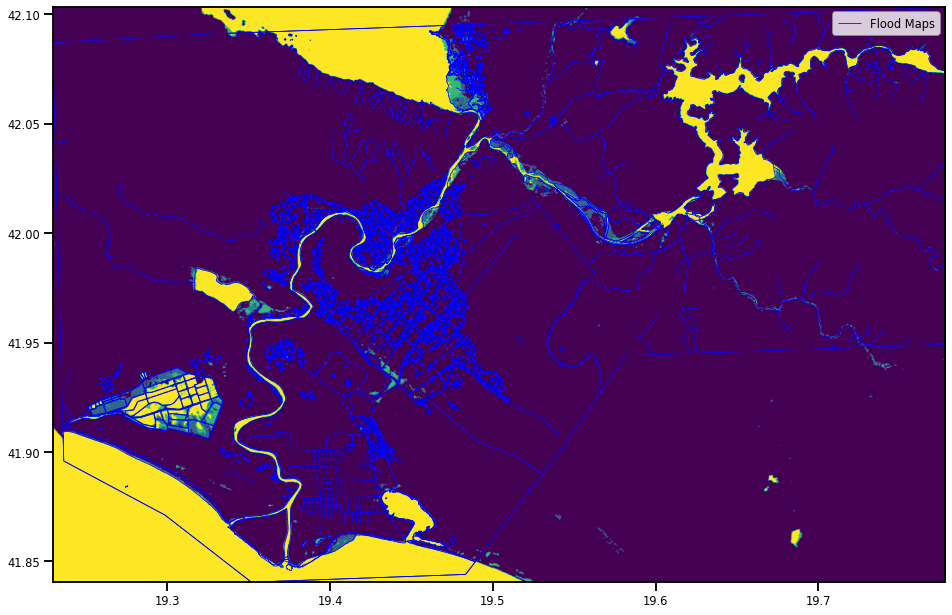

In [13]:
# initialize figure
fig, ax = plt.subplots(figsize=(16,16))

# plot the permanent water
plot_tiff_image(JRC_IMG_PATH, ax=ax, label="Permanent Water")

# plot the floodmap
floodmap_df.plot(ax=ax, facecolor="None", edgecolor="blue", label="Flood Maps", linewidth=0.8)

plt.legend()
plt.show()

So we can see that it's very clear that there is some overlap between the permanent water and the flood maps, but there are also many areas that extend beyond the standard region.

#### Figure - FloodMaps On S2 Image

We can actually overlay the floodmaps onto the S2 Image. Because all of the geocoordinates are consistent, this allows us to visualize all of the pieces together.

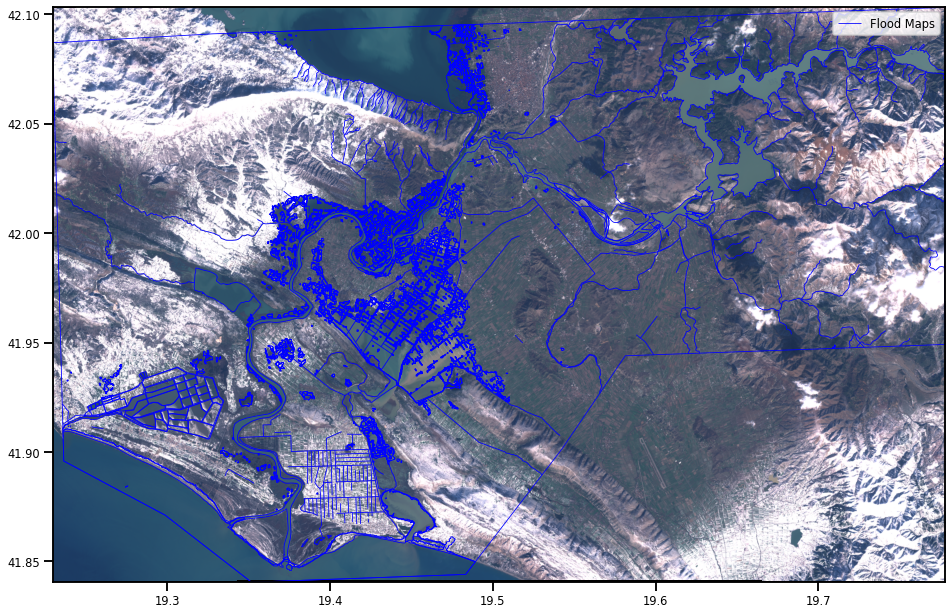

In [14]:
# initialize figure
fig, ax = plt.subplots(figsize=(16,16))

# plot S2 Image
plot_s2_rbg_image(S2_IMG_PATH, ax=ax, label="S2 Image")

# plot the floodmap
floodmap_df.plot(ax=ax, facecolor="None", edgecolor="blue", label="Flood Maps", linewidth=0.8)

plt.legend()
plt.show()

## Ground Truth

So now we've seen all of the bits and pieces needed to get the data required to create the ground truth: 1) S2 Image, 2) Cloud Masks, 3) FloodMaps, 4) Permanent Water. We can now create some ground truth images which can be used for our machine learning problem.

### 3-Class Problem

This first ground truth type is a 3-class problem: Land, Water, Cloud. We basically fuse these four resources together to create the ground truth. So a simple logistic regression model would be able to use this. However, it would probably do poorly due to the complexity of the data.

It's very simple to generate ground truth with the functions we created.

In [15]:
from src.data.create_gt import generate_land_water_cloud_gt

In [16]:
%%time

# Might need to run again if the code breaks.

gt, gt_meta = generate_land_water_cloud_gt(                        
    S2_IMG_PATH,
    FLOODMAP_PATH,
    keep_streams=True,
    cloudprob_in_lastband=True,
    permanent_water_image_path=JRC_IMG_PATH,
)

/home/satyarth934/miniconda3/envs/ml4fl_py38/lib/python3.8/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape None at index 853 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)


CPU times: user 25.9 s, sys: 957 ms, total: 26.9 s
Wall time: 47.7 s


In [17]:
gt_meta

{'gtversion': 'v1',
 'encoding_values': {-1: 'invalid', 0: 'land', 1: 'water', 2: 'cloud'},
 'shape': [2928, 6107],
 's2_image_path': 'EMSR501_AOI01_DEL_MONIT01_r1_v1.tif',
 'permanent_water_image_path': 'EMSR501_AOI01_DEL_MONIT01_r1_v1.tif',
 'cloudprob_tiff': 'None',
 'method clouds': 's2cloudless',
 'pixels invalid S2': 0,
 'pixels clouds S2': 643531,
 'pixels water S2': 3112734,
 'pixels land S2': 14125031,
 'pixels flood water S2': 726299,
 'pixels hydro water S2': 348995,
 'pixels permanent water S2': 2037440,
 'bounds': BoundingBox(left=19.2295166349193, bottom=41.840471662321306, right=19.77811777893109, top=42.1034983775115),
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, 19.2295166349193,
        0.0, -8.983152841195215e-05, 42.1034983775115)}

### Demo

In [18]:
from src.visualization.plot_utils import get_cmap_norm_colors

In [19]:
COLORS = np.array([[0, 0, 0], # invalid
       [139, 64, 0], # land
       [0, 0, 139], # water
       [220, 220, 220]], # cloud
      dtype=np.float32) / 255


labels = ["Invalid", "Land", "Flood water", "Cloud", ]
cmap_cat, norm_cat, patches = get_cmap_norm_colors(COLORS, labels)

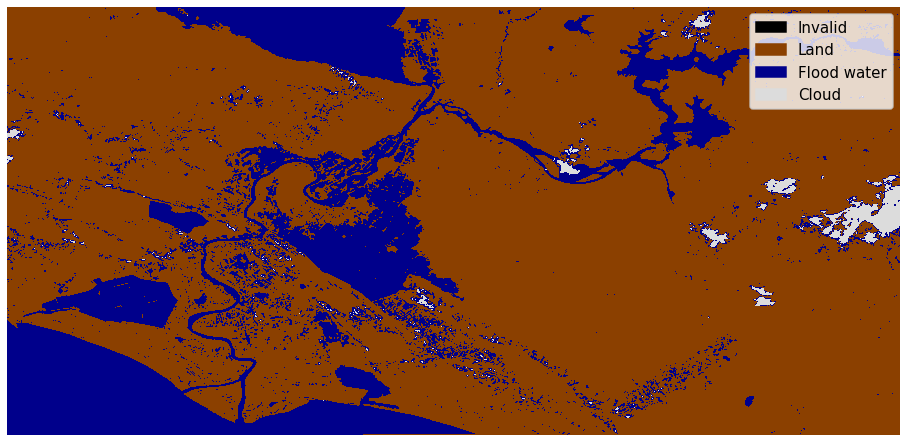

In [20]:
fig, ax = plt.subplots(figsize=(16,16))

im_plt = ax.imshow(gt, cmap=cmap_cat, norm=norm_cat)

ax.legend(
    handles=patches,
    loc='upper right',
    fontsize=15
)
ax.set_axis_off()
plt.show()

## 2-Class Problem

In this ground truth, we generate 2-band ground truth which consists of a binary classification problem for 

#### Meta Data

There is one more dataset we need for the binary class problem, the `floodmap_meta`. This contains some vital information for sorting the into their appropriate parts. It's located in the bucket with the same file structure as all of the other parts as a `json` file.

In [21]:
# Flood Meta Path
FLOOD_META_PATH = "gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/flood_meta/EMSR501/AOI01/EMSR501_AOI01_DEL_MONIT01_r1_v1_metadata_floodmap.pickle"
floodmap_meta = read_pickle_from_gcp(FLOOD_META_PATH)

Now that we have the meta data, we're good to go for generating the ground truth.

In [22]:
from src.data.create_gt import generate_water_cloud_binary_gt

In [23]:
%%time

# Might need to run again if the code breaks.

gt_binary, gt_meta_binary = generate_water_cloud_binary_gt(                        
    S2_IMG_PATH,
    FLOODMAP_PATH,
    metadata_floodmap=floodmap_meta,
    keep_streams=False,
    cloudprob_in_lastband=True,
    permanent_water_image_path=JRC_IMG_PATH,
)

CPU times: user 25.8 s, sys: 1.05 s, total: 26.9 s
Wall time: 46.5 s


In [24]:
COLORS = np.array(
    [[0, 0, 0], # invalid
    [173, 216, 230], # no cloud
    [255, 255, 255]], # cloud
    dtype=np.float32) / 255

labels = ["Invalid", "No Cloud", "Cloud",]
cmap_cat, norm_cat, patches = get_cmap_norm_colors(COLORS, labels)

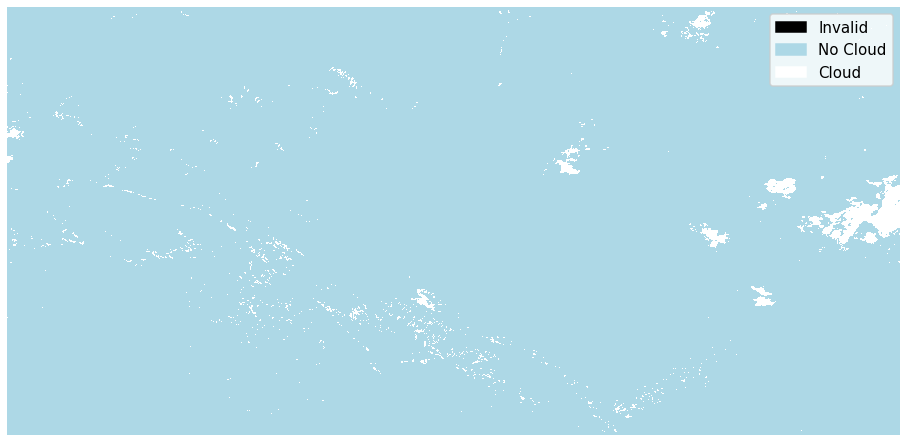

In [25]:
fig, ax = plt.subplots(figsize=(16,16))

im_plt = ax.imshow(gt_binary[0], cmap=cmap_cat, norm=norm_cat)

ax.legend(
    handles=patches,
    loc='upper right',
    fontsize=15
)
ax.set_axis_off()
plt.show()

In [26]:
COLORS = np.array(
    [[0, 0, 0], # invalid
    [139, 64, 0], # land
    [0, 0, 139]], # water
    dtype=np.float32) / 255

labels = ["Invalid", "Land", "Flood water",]
cmap_cat, norm_cat, patches = get_cmap_norm_colors(COLORS, labels)

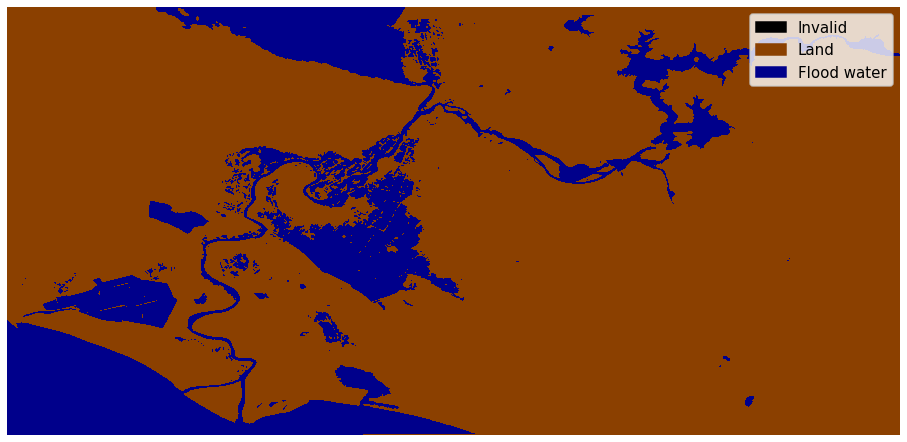

In [27]:
fig, ax = plt.subplots(figsize=(16,16))

im_plt = ax.imshow(gt_binary[1], cmap=cmap_cat, norm=norm_cat)

ax.legend(
    handles=patches,
    loc='upper right',
    fontsize=15
)
ax.set_axis_off()
plt.show()